# Visualizing Government spending data with Pandas and Matplotlib

#### Jakub J.
#### 06.02. 2019

In this notebook I illustrate basic capabilities of python data driven libraries. 
It was your task I received which made me to rediscover the power of these libraries and julia/python/R notebooks.
It also seems more natural and effective compare to loading data into sqlite and then using excel to graph it in a long term.
Recently, I also learned about Dask, which could be used for heavier data sets and is build on pandas syntax for clusters.
Below is my code, it is definitely on heavy handed side but I plan to improve upon this. 
Presentation and math models could also be more advanced. I have some more code for market growth/decline but need to figure out how to plot it in a meaningful way and some other ideas.

Resources I used:

https://pandas.pydata.org/pandas-docs/stable/getting_started/comparison/comparison_with_sql.html
https://matplotlib.org/gallery/pie_and_polar_charts/pie_features.html#sphx-glr-gallery-pie-and-polar-charts-pie-features-py
https://www.theatlantic.com/science/archive/2018/04/the-scientific-paper-is-obsolete/556676/

What can be seen below:

1) Load data, clean them
2) Merge two csv files together for the third step
3) Evaluate market share, market growth/decline in Czech Republic and in three biggest cities evaluate market share based on desription in contracts.csv file VERSUS based on IC from the publishers.csv. (most companies are registered in Prague so it makes huge difference)
    



In [140]:
import pandas as pd                    # data package
import matplotlib as mpl               # graphics package
import seaborn as sns                  # make prettier graphs (havent used here)
import datetime                        # probably not needed now
import sys
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-dark')

# This is an IPython command.  It puts plots here in the notebook, rather than  a separate window.
%matplotlib inline

# check versions
print('Python version:', sys.version)
print('Pandas version: ', pd.__version__)
print('Matplotlib version: ', mpl.__version__)
print('Today: ', dt.date.today())

Python version: 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
Pandas version:  0.23.0
Matplotlib version:  2.2.2
Today:  2019-02-08


In [141]:
#Load government contracts into dataframe
#Load IC and Companies who buys mean tickets 
df = pd.read_csv('contracts.csv',error_bad_lines=False,delimiter=';')
df2 = pd.read_csv('publishers.csv',error_bad_lines=False,delimiter=';')

#filter by keyword straven - some of description also have 'strav' abbreviation but there are only few.
#I could have done something like: If 'strav' but not 'Ostrava', then also include in the dataframe via regex. 

df = df.loc[df.Subject.str.contains("straven", na=False)]

In [142]:
#correct some of the data types

df['SupplierIC'] = df['SupplierIC'].apply(np.int64)
#dfPr['PublisherIC'] = dfPr['PublisherIC'].apply(np.int64)
df['PublisherIC'] = df['PublisherIC'].apply(np.int64)
df['PublishedAtUtc'] =  pd.to_datetime(df['PublishedAtUtc'])

In [143]:
# I wanted to combine/merge two columns with price with vat and without vat so I can make some pie chart or graph based on market share
# so I created new column 'PricePaid at the end of the dataframe'

df['PricePaid']=df['ValueVatExcluded'].fillna(df['ValueVatIncluded'])
df = df.dropna(subset=['PricePaid'])
df['PricePaid'] = df['PricePaid'].apply(np.float64)

# I could save this and user later as original data set after triplechecking it's not distorted for whatever reason.
df.to_csv('filtered.csv') 



In [144]:
#merg = pd.merge(df, df2).sort_values(by=['PricePaid'], ascending=False)
#merg['ValueVatIncluded'] = merg['ValueVatIncluded'].apply(np.float64)


In [145]:
#After looking on Wikipedia for top 3 meal ticket companies I looked to their IC and 
#created three vars based on the company name, then summarized. This should be total amount the companies were paid by government

Sodexo = df.loc[df['SupplierIC'] == 61860476, 'PricePaid'].sum()
Edenred = df.loc[df['SupplierIC'] == 24745391, 'PricePaid'].sum()
Up = df.loc[df['SupplierIC'] == 62913671, 'PricePaid'].sum()

In [156]:
#create dictionary with these three variables

MarketShare = {'Company Name': ['EdenRed', 'Sodexo', 'UP'],
            'PaidTotal': [Edenred, Sodexo, Up]}

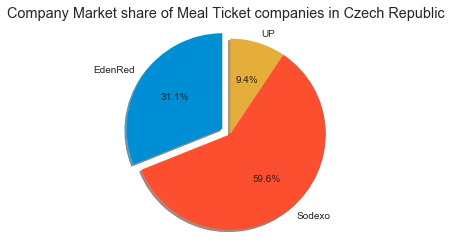

In [157]:
#Create simply pie chart based on sums from the file

PieChartTotal = pd.DataFrame(MarketShare, columns=['Company Name', 'PaidTotal'])
 
sizes = PieChartTotal['PaidTotal']  
labels = PieChartTotal['Company Name']
explode = (0.1, 0, 0)
    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.

ax1.axis('equal')

# https://cs.wikipedia.org/wiki/Stravenka

ax1.set_title("Company Market share of Meal Ticket companies in Czech Republic")
plt.show()


Text(0,0.5,'Amount Paid to meal ticket company')

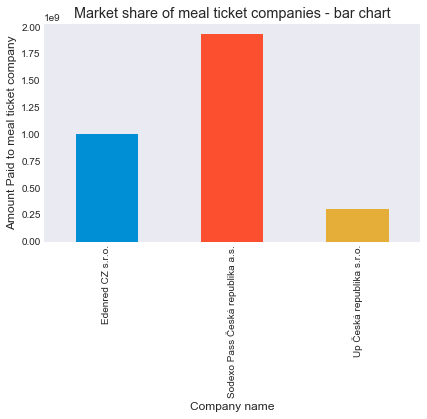

In [148]:
#MarketShareBar is an AxesSubPlot https://matplotlib.org/api/axes_api.html
#Copying dataframe just to avoid changes

ndf = df.copy()
marketShareBar = ndf.groupby('SupplierName')['PricePaid'].sum().plot(kind='bar')

#df.groupby("Rep").sum().sort_values("Total Price", ascending=False).plot(kind='bar')
#marketShareBar = df.groupby('SupplierName')['PricePaid'].sum().sort_values('PricePaid', ascending=False).plot(kind='bar')


marketShareBar.set_title("Market share of meal ticket companies - bar chart")
marketShareBar.set_xlabel("Company name")
marketShareBar.set_ylabel("Amount Paid to meal ticket company")

#sort_index(axis='columns')
#marketShareBar.legend(ndf['SupplierName'])
#marketShareBar.get_legend().remove()


In [194]:
ndf.dtypes

ContractId                  object
VersionId                   object
Subject                     object
PublishedAtUtc      datetime64[ns]
ValueVatExcluded           float64
ValueVatIncluded            object
SupplierIC                   int64
SupplierName                object
PublisherIC                  int64
PricePaid                  float64
dtype: object

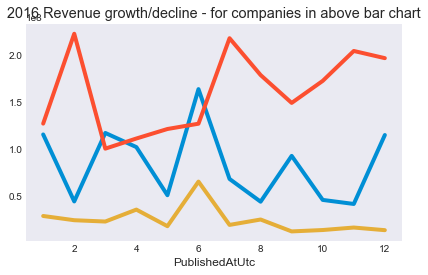

In [210]:


sums = ndf.groupby(['SupplierName', ndf.PublishedAtUtc.dt.month])['PricePaid'].sum().reset_index(level=0) 
for company in sums['SupplierName'].unique():
    sums[sums['SupplierName'] == company]['PricePaid'].plot(title="2016 Revenue growth/decline - for companies in above bar chart");

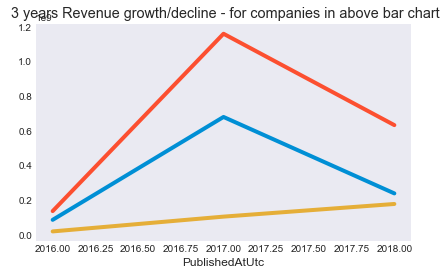

In [211]:
sums = ndf.groupby(['SupplierName', ndf.PublishedAtUtc.dt.year])['PricePaid'].sum().reset_index(level=0) 
for company in sums['SupplierName'].unique():
    sums[sums['SupplierName'] == company]['PricePaid'].plot(title=" 3 years Revenue growth/decline - for companies in above bar chart");

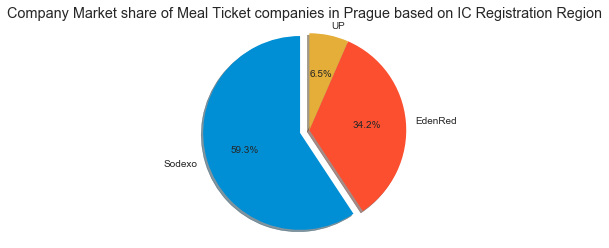

In [212]:
dfPr = pd.read_csv('publishers.csv',error_bad_lines=False,delimiter=';')
dfPr = df2.loc[df2.Region.str.contains("Praha", na=False)]
Merged_Prague = pd.merge(df, dfPr, on=['PublisherIC'])

#test =test[test['PublisherName'] == 'Generální finanční ředitelství'].sort_values(by=['PricePaid'], ascending = False)


Merged_Prague['SupplierIC'] = Merged_Prague['SupplierIC'].apply(np.int64)
Merged_Prague['PublisherIC'] = Merged_Prague['PublisherIC'].apply(np.int64)

Sodexo_PragueIC = Merged_Prague.loc[Merged_Prague['SupplierIC'] == 61860476, 'PricePaid'].sum()
Edenred_PragueIC = Merged_Prague.loc[Merged_Prague['SupplierIC'] == 24745391, 'PricePaid'].sum()
Up_PragueIC = Merged_Prague.loc[Merged_Prague['SupplierIC'] == 62913671, 'PricePaid'].sum()

MarketShare_PragueIC = {'Company Name': ['Sodexo', 'EdenRed', 'UP'],
            'PaidTotal': [Sodexo_PragueIC, Edenred_PragueIC, Up_PragueIC]}

PieChartTotal_IC = pd.DataFrame(MarketShare_PragueIC, columns=['Company Name', 'PaidTotal'])
 
sizes = PieChartTotal_IC['PaidTotal']  
labels = PieChartTotal_IC['Company Name']
explode = (0.1, 0, 0)
    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.

ax1.axis('equal')

# https://cs.wikipedia.org/wiki/Stravenka

ax1.set_title("Company Market share of Meal Ticket companies in Prague based on IC Registration Region")
plt.show()



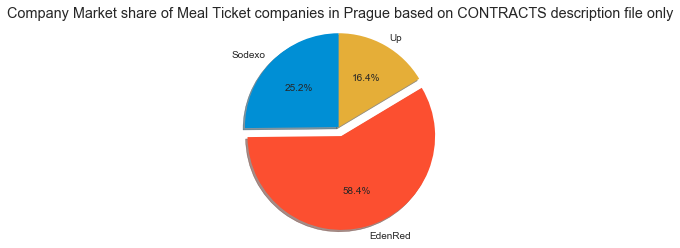

In [213]:
Prague = df.loc[df.Subject.str.contains("Praha", na=False)]
Sodexo_Pr = Prague.loc[Prague['SupplierIC'] == 61860476, 'PricePaid'].sum()
Edenred_Pr = Prague.loc[Prague['SupplierIC'] == 24745391, 'PricePaid'].sum()
Up_Pr = Prague.loc[Prague['SupplierIC'] == 62913671, 'PricePaid'].sum()

MarketSharePr = {'Company Name': ['Sodexo', 'EdenRed', 'Up'],
                   'PaidTotal': [Sodexo_Pr, Edenred_Pr, Up_Pr]}

PieChartPr = pd.DataFrame(MarketSharePr, columns=['Company Name', 'PaidTotal'])


sizes = PieChartPr['PaidTotal']  
labels = PieChartPr['Company Name']
explode = (0, 0.1, 0)
    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')
# https://cs.wikipedia.org/wiki/Stravenka
ax1.set_title("Company Market share of Meal Ticket companies in Prague based on CONTRACTS description file only")
plt.show()

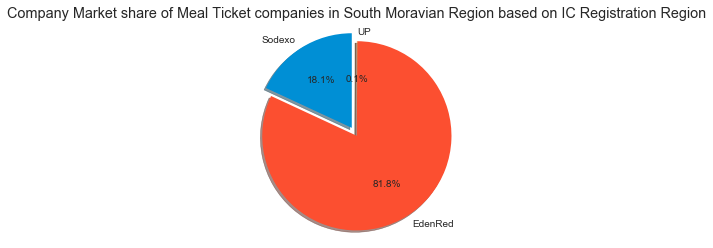

In [214]:
dfJMorava = df2.loc[df2.Region.str.contains("Jihomoravský kraj", na=False)]
Merged_JMorava = pd.merge(df, dfJMorava, on=['PublisherIC'])

Merged_JMorava['SupplierIC'] = Merged_JMorava['SupplierIC'].apply(np.int64)
Merged_JMorava['PublisherIC'] = Merged_JMorava['PublisherIC'].apply(np.int64)

Sodexo_JMoravaIC = Merged_JMorava.loc[Merged_JMorava['SupplierIC'] == 61860476, 'PricePaid'].sum()
Edenred_JMoravaIC = Merged_JMorava.loc[Merged_JMorava['SupplierIC'] == 24745391, 'PricePaid'].sum()
Up_JMoravaIC = Merged_JMorava.loc[Merged_JMorava['SupplierIC'] == 62913671, 'PricePaid'].sum()

MarketShare_JMoravaIC = {'Company Name': ['Sodexo', 'EdenRed', 'UP'],
            'PaidTotal': [Sodexo_JMoravaIC, Edenred_JMoravaIC, Up_JMoravaIC]}

PieChartTotal_IC = pd.DataFrame(MarketShare_JMoravaIC, columns=['Company Name', 'PaidTotal'])
 
sizes = PieChartTotal_IC['PaidTotal']  
labels = PieChartTotal_IC['Company Name']
explode = (0.1, 0, 0)
    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.

ax1.axis('equal')

# https://cs.wikipedia.org/wiki/Stravenka

ax1.set_title("Company Market share of Meal Ticket companies in South Moravian Region based on IC Registration Region")
plt.show()


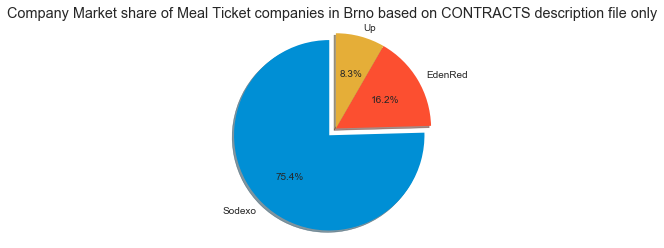

In [215]:
# Market share for Brno

Brno = df.loc[df.Subject.str.contains("Brno", na=False)]
Sodexo_Br = Brno.loc[Brno['SupplierIC'] == 61860476, 'PricePaid'].sum()
Edenred_Br = Brno.loc[Brno['SupplierIC'] == 24745391, 'PricePaid'].sum()
Up_Br = Brno.loc[Brno['SupplierIC'] == 62913671, 'PricePaid'].sum()

MarketShareBr = {'Company Name': ['Sodexo', 'EdenRed', 'Up'],
                   'PaidTotal': [Sodexo_Br, Edenred_Br, Up_Br]}

PieChartBr = pd.DataFrame(MarketShareBr, columns=['Company Name', 'PaidTotal'])


sizes = PieChartBr['PaidTotal']  
labels = PieChartBr['Company Name']
explode = (0.1, 0, 0)
    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')
# https://cs.wikipedia.org/wiki/Stravenka
ax1.set_title("Company Market share of Meal Ticket companies in Brno based on CONTRACTS description file only")
plt.show()

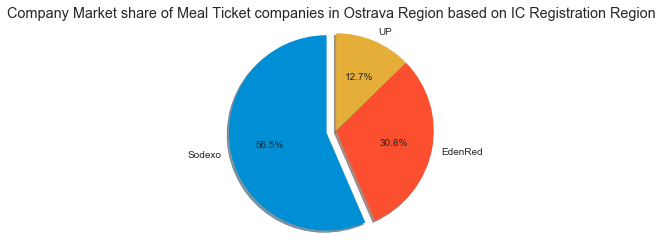

In [216]:
dfOstravaRegion = df2.loc[df2.Region.str.contains("Moravskoslezský kraj", na=False)]
Merged_OstravaRegion = pd.merge(df, dfOstravaRegion, on=['PublisherIC'])

Merged_OstravaRegion['SupplierIC'] = Merged_OstravaRegion['SupplierIC'].apply(np.int64)
Merged_OstravaRegion['PublisherIC'] = Merged_OstravaRegion['PublisherIC'].apply(np.int64)

Sodexo_OstravaRegion = Merged_OstravaRegion.loc[Merged_OstravaRegion['SupplierIC'] == 61860476, 'PricePaid'].sum()
Edenred_OstravaRegion = Merged_OstravaRegion.loc[Merged_OstravaRegion['SupplierIC'] == 24745391, 'PricePaid'].sum()
Up_OstravaRegion = Merged_OstravaRegion.loc[Merged_OstravaRegion['SupplierIC'] == 62913671, 'PricePaid'].sum()

MarketShare_OstravaRegion = {'Company Name': ['Sodexo', 'EdenRed', 'UP'],
            'PaidTotal': [Sodexo_OstravaRegion, Edenred_OstravaRegion, Up_OstravaRegion]}

PieChartTotal_IC = pd.DataFrame(MarketShare_OstravaRegion, columns=['Company Name', 'PaidTotal'])
 
sizes = PieChartTotal_IC['PaidTotal']  
labels = PieChartTotal_IC['Company Name']
explode = (0.1, 0, 0)
    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.

ax1.axis('equal')

# https://cs.wikipedia.org/wiki/Stravenka

ax1.set_title("Company Market share of Meal Ticket companies in Ostrava Region based on IC Registration Region")
plt.show()


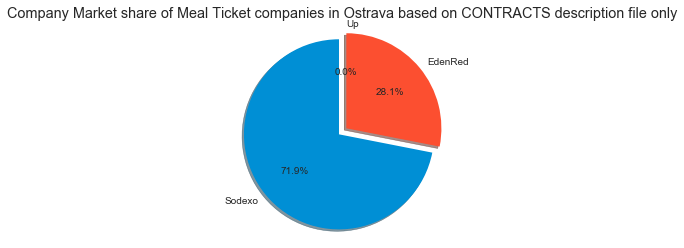

In [217]:
# Market share for ostrava

Ostrava = df.loc[df.Subject.str.contains("Ostrava", na=False)]
Sodexo_Os = Ostrava.loc[Ostrava['SupplierIC'] == 61860476, 'PricePaid'].sum()
Edenred_Os = Ostrava.loc[Ostrava['SupplierIC'] == 24745391, 'PricePaid'].sum()
Up_Os = Ostrava.loc[Ostrava['SupplierIC'] == 62913671, 'PricePaid'].sum()

MarketShareOs = {'Company Name': ['Sodexo', 'EdenRed', 'Up'],
                   'PaidTotal': [Sodexo_Os, Edenred_Os, Up_Os]}

PieChartOs = pd.DataFrame(MarketShareOs, columns=['Company Name', 'PaidTotal'])


sizes = PieChartOs['PaidTotal']  
labels = PieChartOs['Company Name']
explode = (0.1, 0, 0)
    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')
# https://cs.wikipedia.org/wiki/Stravenka
ax1.set_title("Company Market share of Meal Ticket companies in Ostrava based on CONTRACTS description file only")
plt.show()